In [1]:
from collections import Counter
import nltk
import string
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from avaml.aggregatedata import download
from avaml import Error, varsomdata, setenvironment as se, _NONE, CSV_VERSION, REGIONS, merge
from avaml.get_text_data import TextDataset
from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError

from utils.preprocess import preprocess

Varsom data has class in API, class Avalanche Warning, avalanche danger message is here:
https://github.com/NVE/varsomdata/blob/471a0e368e3f69352f27d73cb19ce8efa82d9467/varsomdata/getforecastapi.py

In [2]:
model_prefix = ''
days = 1
regobs_types = list(REG_ENG.keys())
text_data = TextDataset(regobs_types=regobs_types).label(days, with_varsom=True)

Fetching online data. (This may take a long time.)
    Getting data for season: 2017-18
    Getting data for season: 2018-19
    Getting data for season: 2019-20
Done!

Creating labeled dataset.
Done!


In [3]:
vars(text_data).keys()

dict_keys(['data', 'danger_text', 'row_weight', 'label', 'pred', 'days', 'with_varsom', 'regobs_types', 'single', 'seasons', 'with_regions'])

In [4]:
# flatten and encode columns
text_data = preprocess(text_data)

# reorder indices so that regions are first
text_data.data = text_data.data.reorder_levels([1, 0])
text_data.label = text_data.label.reorder_levels([1, 0])
text_data.danger_text = text_data.danger_text.reorder_levels([1, 0])

# extract different keys from dictionary
data = text_data.data
labels = text_data.label
text = text_data.danger_text

In [5]:
text

,,danger_text
3031,2017-11-22,Vurderingen av snøskredfaren baseres hovedsake...
3034,2017-11-22,Vurderingen av snøskredfaren baseres hovedsake...
3031,2017-11-23,Vurderingen av snøskredfaren baseres hovedsake...
3034,2017-11-23,Vurderingen av snøskredfaren baseres hovedsake...
3007,2017-11-29,Et polart lavtrykk gir kraftig vind og enkelte...
...,...,...
3031,2021-01-12,"Vinden øker på igjen tirsdag, men fra nord, og..."
3032,2021-01-12,"Vinden øker på igjen tirsdag, men fra nord, og..."
3034,2021-01-12,"Vinden øker på igjen tirsdag, men fra nord, og..."
3035,2021-01-12,"Vinden øker på igjen tirsdag, men fra nord, og..."


# Clustering text by danger level, avalanche problem 1 and 2

## Danger level

In [6]:
np.unique(labels['CLASS_danger_level'])

array([1, 2, 3, 4])

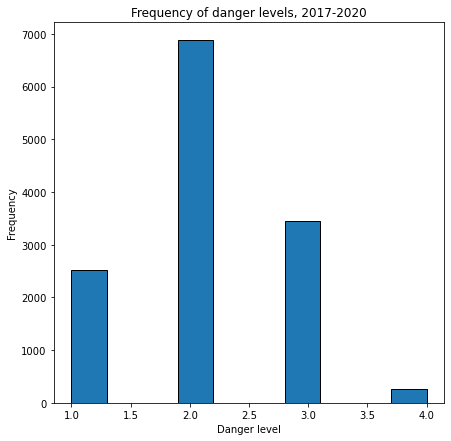

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.hist(labels['CLASS_danger_level'].values, edgecolor='k')

ax.set_xlabel('Danger level')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of danger levels, 2017-2020')
plt.show()

So most of the time the danger level is 1 or 2, although 3 is not uncommon. A danger level of 4 is rare.

Next, we can isolate where the danger level is either 1, 2, 3, or 4 and then use that to select text on those days.

In [8]:
dlevel1_idx = labels.index[np.where(labels['CLASS_danger_level'] == 1)[0]]
dlevel2_idx = labels.index[np.where(labels['CLASS_danger_level'] == 2)[0]]
dlevel3_idx = labels.index[np.where(labels['CLASS_danger_level'] == 3)[0]]
dlevel4_idx = labels.index[np.where(labels['CLASS_danger_level'] == 4)[0]]

In [9]:
# make sure these dates show up in the indexed labels and main text messages
dlevel1_idx

MultiIndex([(3003, '2017-12-02'),
            (3003, '2017-12-03'),
            (3035, '2017-12-03'),
            (3003, '2017-12-04'),
            (3035, '2017-12-04'),
            (3003, '2017-12-05'),
            (3003, '2017-12-06'),
            (3014, '2017-12-12'),
            (3013, '2017-12-14'),
            (3013, '2017-12-15'),
            ...
            (3017, '2021-01-11'),
            (3006, '2021-01-12'),
            (3009, '2021-01-12'),
            (3010, '2021-01-12'),
            (3011, '2021-01-12'),
            (3012, '2021-01-12'),
            (3013, '2021-01-12'),
            (3014, '2021-01-12'),
            (3015, '2021-01-12'),
            (3017, '2021-01-12')],
           names=['region', 'date'], length=2525)

In [10]:
labels.loc[dlevel1_idx]

CLASS_danger_level  CLASS_emergency_warning  \
region date                                                      
3003   2017-12-02                   1                        0   
       2017-12-03                   1                        0   
3035   2017-12-03                   1                        0   
3003   2017-12-04                   1                        0   
3035   2017-12-04                   1                        0   
...                               ...                      ...   
3012   2021-01-12                   1                        0   
3013   2021-01-12                   1                        0   
3014   2021-01-12                   1                        0   
3015   2021-01-12                   1                        0   
3017   2021-01-12                   1                        0   

                   CLASS_problem_1  CLASS_problem_2  CLASS_problem_3  \
region date                                                            
3003   2017-12-02                1                0                0   
       2017-12-03                1                0                0   
3035   2017-12-03                1                0                0   
3003   2017-12-04                1                0                0   
3035   2017-12-04                1                0                0   
...                            ...              ...              ...   
3012   2021-01-12                5                0                0   
3013   2021-01-12                5                0                0   
3014   2021-01-12                5                0                0   
3015   2021-01-12                5                0                0   
3017   2021-01-12                5                0                0   

                   CLASS_problem_amount CLASS_drift_slab_cause  \
region date                                                      
3003   2017-12-02                     1              snowdrift   
       2017-12-03                     1              snowdrift   
3035   2017-12-03                     1               new-snow   
3003   2017-12-04                     1              snowdrift   
3035   2017-12-04                     1               new-snow   
...                                 ...                    ...   
3012   2021-01-12                     1                      0   
3013   2021-01-12                     1                      0   
3014   2021-01-12                     1                      0   
3015   2021-01-12                     1                      0   
3017   2021-01-12                     1                      0   

                   CLASS_drift_slab_dist  CLASS_drift_slab_dsize  \
region date                                                        
3003   2017-12-02                      1                       2   
       2017-12-03                      1                       2   
3035   2017-12-03                      2                       1   
3003   2017-12-04                      1                       2   
3035   2017-12-04                      2                       1   
...                                  ...                     ...   
3012   2021-01-12                      0                       0   
3013   2021-01-12                      0                       0   
3014   2021-01-12                      0                       0   
3015   2021-01-12                      0                       0   
3017   2021-01-12                      0                       0   

                   CLASS_drift_slab_lev_fill  ...  REAL_new_loose_lev_max  \
region date                                   ...                           
3003   2017-12-02                          1  ...                     0.0   
       2017-12-03                          1  ...                     0.0   
3035   2017-12-03                          1  ...                     0.0   
3003   2017-12-04                          1  ...                     0.0   
3035   2017-12-04

In [11]:
# this should only contain one value, in this case '1'
np.unique(labels.loc[dlevel1_idx]['CLASS_danger_level'])

array([1])

In [12]:
text_dlevel1 = text.loc[dlevel1_idx]
text_dlevel1

danger_text
region date                                                         
3003   2017-12-02  Det er lite snø og generelt stabile forhold i ...
       2017-12-03  Det er lite snø og generelt stabile forhold i ...
3035   2017-12-03  Det ventes kaldere temperatur. Det ligger fort...
3003   2017-12-04  Det er lite snø og generelt stabile forhold i ...
3035   2017-12-04  Det ventes kalde temperaturer. Det kan fortsat...
...                                                              ...
3012   2021-01-12  Det er generelt stabile forhold, men vær varso...
3013   2021-01-12  Under ca 500 moh er svært stabile forhold.\nMe...
3014   2021-01-12  Det er svært lite snø i regionen nå og på værf...
3015   2021-01-12  Vinden fortsetter, men det er nå svært lite lø...
3017   2021-01-12  Vinden øker igjen, men det er lite løs snø til...

[2525 rows x 1 columns]

In [13]:
text_dlevel2 = text.loc[dlevel2_idx]
text_dlevel2

,,danger_text
region,date,
3007,2017-12-02,Skredfaren styres av utbredelsen av et vedvare...
3009,2017-12-02,Skredfaren styres av utbredelsen av et vedvare...
3010,2017-12-02,Skredfaren styres av tilstedeværelse av vedvar...
3011,2017-12-02,Skredfaren styres av tilstedeværelse av vedvar...
3012,2017-12-02,Skredfaren styres av tilstedeværelse av vedvar...
...,...,...
3003,2021-01-12,Litt nedbør i kombinasjon med vind kan legge o...
3007,2021-01-12,Det er lite løs snø tilgjengelig for transport...
3016,2021-01-12,"Fortsatt sterk vind i fjellet, men det er lite..."


In [14]:
text_dlevel3 = text.loc[dlevel3_idx]
text_dlevel3

,,danger_text
region,date,
3016,2017-12-02,Fredagens og lødagens nysnø kombinert med vind...
3017,2017-12-02,Det ventes lokalt mye nysnø på lørdag. På vind...
3031,2017-12-02,Det forventes en del skredaktivitet i alle him...
3034,2017-12-02,Det forventes en del skredaktivitet i alle him...
3014,2017-12-03,Kraftig vind og siste dagers nysnø vil øke utb...
...,...,...
3031,2021-01-12,"Vinden øker på igjen tirsdag, men fra nord, og..."
3032,2021-01-12,"Vinden øker på igjen tirsdag, men fra nord, og..."
3034,2021-01-12,"Vinden øker på igjen tirsdag, men fra nord, og..."


In [15]:
text_dlevel4 = text.loc[dlevel4_idx]
text_dlevel4

danger_text
region date                                                         
3031   2017-11-23  Vurderingen av snøskredfaren baseres hovedsake...
3034   2017-11-23  Vurderingen av snøskredfaren baseres hovedsake...
       2017-12-05  Svært store mengder nedbør kombinert med kraft...
3022   2017-12-23  NB! Lokalt store nedbørsmengder og vind natt t...
3023   2017-12-23  NB. Lokalt store nedbørsmengder og vind natt t...
...                                                              ...
       2020-04-15  Stigende temperatur, kraftig vind og nedbør ve...
3024   2020-04-15  Stigende temperatur, kraftig vind og nedbør ve...
3027   2020-04-15  Stigende temperatur, kraftig vind og nedbør ve...
3022   2020-05-20  Stigende temperatur og kraftig solinnstråling ...
3023   2020-05-20  Stigende temperatur og kraftig solinnstråling ...

[268 rows x 1 columns]

Checking the shapes of each dataframe and comparing it to the values in the histogram, these seem correct.

In [16]:
print('There are {} main messages in danger level 1, and {} of them are unique.'.format(len(text_dlevel1), len(np.unique(text_dlevel1))))
print('There are {} main messages in danger level 2, and {} of them are unique.'.format(len(text_dlevel2), len(np.unique(text_dlevel2))))
print('There are {} main messages in danger level 3, and {} of them are unique.'.format(len(text_dlevel3), len(np.unique(text_dlevel3))))
print('There are {} main messages in danger level 4, and {} of them are unique.'.format(len(text_dlevel4), len(np.unique(text_dlevel4))))

There are 2525 main messages in danger level 1, and 1903 of them are unique.
There are 6876 main messages in danger level 2, and 6097 of them are unique.
There are 3441 main messages in danger level 3, and 3005 of them are unique.
There are 268 main messages in danger level 4, and 226 of them are unique.


We can already see some patterns in how the main text message is written depending on what the danger level is. Interestingly, some of the avalanche danger text messages seem to be used word-for-word more than once, but this is probably due to people filling out the bulletin copy and pasting a given message for similar conditions on back-to-back days, for instance. I am also guessing that there are many similar messages, many fewer types than the unique number of messages implies (word order is changed, or a few words are different but the meaning is the same).

### Data processing
Some processing steps we might want to take for computing correlations between danger levels and word usage are:
- tokenize long strings into individual words
- lowercase each token
- remove stopwords
- tokenize by word
- remove semantic information
- split contractions for removal
- remove punctuation
- remove stop words
- remove non-alphabetic characters

In [17]:
# you will need to download the stopwords corpora from nltk 
# before moving on in this Notebook
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jakidxav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stopwords = nltk.corpus.stopwords.words('norwegian')
print(stopwords)

['og', 'i', 'jeg', 'det', 'at', 'en', 'et', 'den', 'til', 'er', 'som', 'på', 'de', 'med', 'han', 'av', 'ikke', 'ikkje', 'der', 'så', 'var', 'meg', 'seg', 'men', 'ett', 'har', 'om', 'vi', 'min', 'mitt', 'ha', 'hadde', 'hun', 'nå', 'over', 'da', 'ved', 'fra', 'du', 'ut', 'sin', 'dem', 'oss', 'opp', 'man', 'kan', 'hans', 'hvor', 'eller', 'hva', 'skal', 'selv', 'sjøl', 'her', 'alle', 'vil', 'bli', 'ble', 'blei', 'blitt', 'kunne', 'inn', 'når', 'være', 'kom', 'noen', 'noe', 'ville', 'dere', 'som', 'deres', 'kun', 'ja', 'etter', 'ned', 'skulle', 'denne', 'for', 'deg', 'si', 'sine', 'sitt', 'mot', 'å', 'meget', 'hvorfor', 'dette', 'disse', 'uten', 'hvordan', 'ingen', 'din', 'ditt', 'blir', 'samme', 'hvilken', 'hvilke', 'sånn', 'inni', 'mellom', 'vår', 'hver', 'hvem', 'vors', 'hvis', 'både', 'bare', 'enn', 'fordi', 'før', 'mange', 'også', 'slik', 'vært', 'være', 'båe', 'begge', 'siden', 'dykk', 'dykkar', 'dei', 'deira', 'deires', 'deim', 'di', 'då', 'eg', 'ein', 'eit', 'eitt', 'elles', 'honom'

In [19]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [20]:
def lower_case(tokens):
    """
    Convert all tokens to lowercase. Assumes that tokenizing has already occurred.
    """
    return [token.lower() for token in tokens]

In [21]:
def remove_stopwords(tokens):
    """
    This method removes NLTK stopwords. Currently, this method works for Norwegian stopwords.
    More work can be done to input a "language" parameter to make it more customizable by language.
    """
    # create stopwords set for Norwegian.
    # this list can be modified in the norwegian.txt file for NLTK, or use this syntax:
    # stopwords.extend(your_list_here)
    stopwords = nltk.corpus.stopwords.words('norwegian')
    return [token for token in tokens if token not in stopwords]

In [22]:
def strip_punctuation(tokens):
    """
    Remove punctuation and replace it with an empty string character.
    Example: can't --> cant, okay? --> okay
    """
    # create punctuation list: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    punctuation = string.punctuation

    # see docs: str.maketrans() will make a table to pass to str.translate()
    table = str.maketrans('', '', string.punctuation)
    return [token.translate(table) for token in tokens]

In [23]:
def remove_numbers(tokens):
    """
    Strip any non-alphabetic characters from a list of tokens.
    """
    return [token for token in tokens if token.isalpha()]

Now we should begin splitting apart the main messages into individual characters for processing. It will be easier to do so if each `avalanche_danger` text message data frame were split into a list.

In [24]:
def process(word_list):
    """
    Customizable method for processing strings, returns list of processed tokens.
    """
    # first, extract string values from an array of strings
    # then create a list of split tokens for each main text string
    # this is the tokenizing step
    token_list = [string[0] for string in word_list]
    token_list = [string.split() for string in token_list]
    to_lowercase = [lower_case(token) for token in token_list]
    no_stopwords = [remove_stopwords(token) for token in to_lowercase]
    no_punctuation = [strip_punctuation(token) for token in no_stopwords]
    no_numbers = [remove_numbers(token) for token in no_punctuation]
    
    return token_list, no_numbers

In [25]:
dlevel1_raw, dlevel1_processed = process(text_dlevel1.values)
dlevel2_raw, dlevel2_processed = process(text_dlevel2.values)
dlevel3_raw, dlevel3_processed = process(text_dlevel3.values)
dlevel4_raw, dlevel4_processed = process(text_dlevel4.values)

In [26]:
dlevel1_raw[0]

['Det',
 'er',
 'lite',
 'snø',
 'og',
 'generelt',
 'stabile',
 'forhold',
 'i',
 'regionen.',
 'Det',
 'er',
 'kun',
 'i',
 'enkelte',
 'bratte',
 'leformasjoner',
 'som',
 'har',
 'samlet',
 'mye',
 'snø',
 'at',
 'det',
 'er',
 'mulig',
 'å',
 'løse',
 'ut',
 'snøskred.']

In [27]:
dlevel1_processed[0]

['lite',
 'snø',
 'generelt',
 'stabile',
 'forhold',
 'regionen',
 'enkelte',
 'bratte',
 'leformasjoner',
 'samlet',
 'mye',
 'snø',
 'mulig',
 'løse',
 'snøskred']

Now we could count the top *n* words, say 25 or some other value of our choosing, for each danger level and then plot that as a histogram.

In [28]:
def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # nested list to flattened list
    flatten_list = [word for list_ in text for word in list_]
    
    # count words
    word_count = Counter(flatten_list)
    
    # sort words by count
    vocab = sorted(word_count, key=word_count.get, reverse=True)
    
    # create dictionary with unique words as keys, counts as values
    vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
    
    # now invert the key, value mapping 
    int_to_vocab = {ii:word for word, ii in vocab_to_int.items()}

    # return tuple
    return (vocab, word_count, vocab_to_int, int_to_vocab)

In [29]:
vocab1, word_count1, _, _ = create_lookup_tables(dlevel1_processed)
vocab2, word_count2, _, _ = create_lookup_tables(dlevel2_processed)
vocab3, word_count3, _, _ = create_lookup_tables(dlevel3_processed)
vocab4, word_count4, _, _ = create_lookup_tables(dlevel4_processed)

In [30]:
to_print = 10
vocab1[:to_print]

['snødekket',
 'små',
 'snø',
 'skred',
 'generelt',
 'vær',
 'våte',
 'fokksnøflak',
 'forhold',
 'enkelte']

In [31]:
[[word, word_count1[word]] for word in vocab1[:to_print]]

[['snødekket', 1728],
 ['små', 1403],
 ['snø', 1337],
 ['skred', 1308],
 ['generelt', 1085],
 ['vær', 1068],
 ['våte', 953],
 ['fokksnøflak', 912],
 ['forhold', 908],
 ['enkelte', 809]]

In [32]:
def top_n_words(vocab, word_count, n):
    """
    Return the top *n* words given a list of words and their 
    frequencies as a dictionary.
    """
    top_words = vocab[:n]
    top_counts = [word_count[word] for word in top_words]
    return top_words, top_counts

In [33]:
n = 25
top_words1, top_counts1 = top_n_words(vocab1, word_count1, n)
top_words2, top_counts2 = top_n_words(vocab2, word_count2, n)
top_words3, top_counts3 = top_n_words(vocab3, word_count3, n)
top_words4, top_counts4 = top_n_words(vocab4, word_count4, n)

In [34]:
def plot_top_word_counts(top_words, top_counts, danger_level, title='danger level'):
    fig, ax = plt.subplots(figsize=(7, 7))

    ax.barh(top_words[::-1], top_counts[::-1])

    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')
    ax.set_title('Top word counts for {} {}, 2017-2020'.format(title, danger_level))

    plt.show()

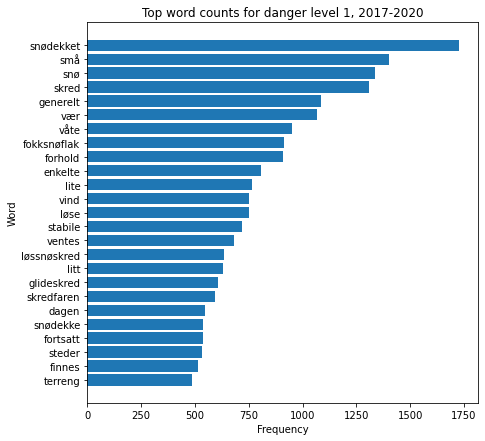

In [35]:
plot_top_word_counts(top_words1, top_counts1, 1)

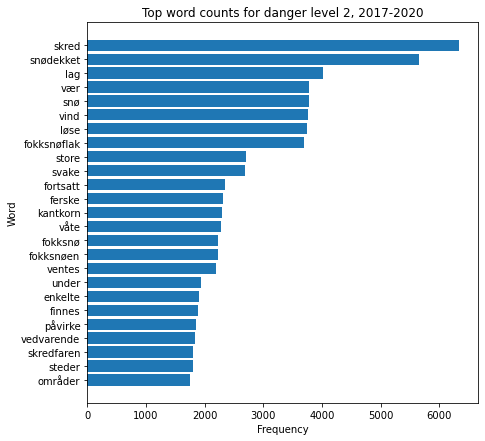

In [36]:
plot_top_word_counts(top_words2, top_counts2, 2)

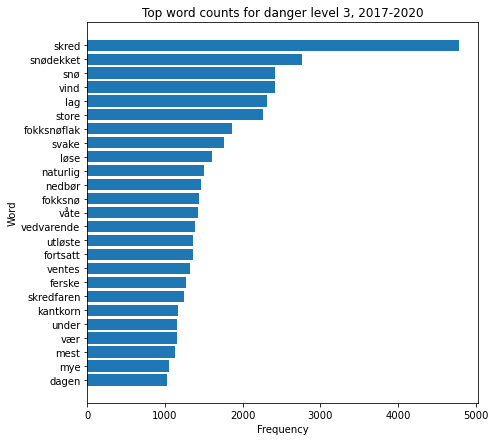

In [37]:
plot_top_word_counts(top_words3, top_counts3, 3)

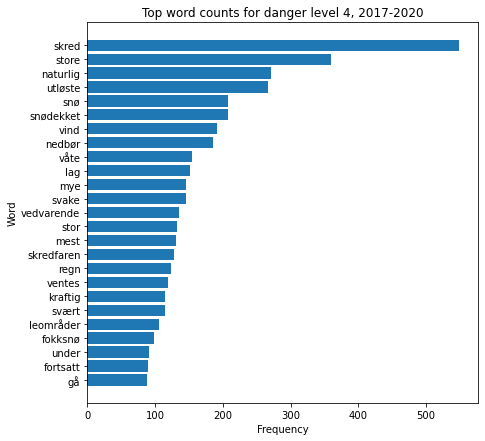

In [38]:
plot_top_word_counts(top_words4, top_counts4, 4)

**I will need to look at how to reduce which words are included here. For example, vær is included as is skred, both of which you might expect from something written on an avalanche bulletin. Maybe running correlations will yield better results, but I suspect I will have to do more reduce the types of words in each danger level list.**

However, it is encouraging that as we progress up in danger level, words like:
- skred
- ustabile
- kraftig
- store
- utløste
- forsiktig
- etc.

also increase in frequency.

## Avalanche problem 1

In [39]:
np.unique(labels['CLASS_problem_1'])

array([0, 1, 2, 3, 4, 5, 6, 7])

In [40]:
prob0_idx = labels.index[np.where(labels['CLASS_problem_1'] == 0)[0]]
prob1_idx = labels.index[np.where(labels['CLASS_problem_1'] == 1)[0]]
prob2_idx = labels.index[np.where(labels['CLASS_problem_1'] == 2)[0]]
prob3_idx = labels.index[np.where(labels['CLASS_problem_1'] == 3)[0]]
prob4_idx = labels.index[np.where(labels['CLASS_problem_1'] == 4)[0]]
prob5_idx = labels.index[np.where(labels['CLASS_problem_1'] == 5)[0]]
prob6_idx = labels.index[np.where(labels['CLASS_problem_1'] == 6)[0]]
prob7_idx = labels.index[np.where(labels['CLASS_problem_1'] == 7)[0]]

In [41]:
prob0_idx

MultiIndex([(3016, '2017-12-15'),
            (3017, '2017-12-16'),
            (3014, '2018-02-02'),
            (3017, '2018-02-02'),
            (3014, '2018-02-03'),
            (3014, '2018-02-04'),
            (3037, '2018-02-12'),
            (3006, '2018-03-02'),
            (3014, '2018-05-17'),
            (3014, '2018-05-18'),
            (3014, '2018-05-19'),
            (3014, '2018-05-20'),
            (3022, '2018-12-02'),
            (3023, '2018-12-02'),
            (3031, '2018-12-23'),
            (3024, '2019-02-27'),
            (3037, '2019-05-17'),
            (3037, '2019-05-18'),
            (3037, '2019-05-19'),
            (3037, '2019-05-20'),
            (3037, '2019-05-21'),
            (3037, '2019-05-22'),
            (3037, '2019-05-23'),
            (3037, '2019-05-24'),
            (3037, '2019-05-25')],
           names=['region', 'date'])

In [42]:
# this should only contain one value, in this case '0'
np.unique(labels.loc[prob0_idx]['CLASS_problem_1'])

array([0])

In [43]:
text.loc[prob0_idx]

danger_text
region date                                                         
3016   2017-12-15  Snøbyger og litt vind onsdag/torsdag kan ha sk...
3017   2017-12-16  Bygenedbør og tidvis en del vind fra vestlig k...
3014   2018-02-02  Vinden fra igår har tatt knekken på mye av ove...
3017   2018-02-02  Østavinden fortsetter, men det er lite løs snø...
3014   2018-02-03  Snødekket er generelt sett stabilt til tross f...
       2018-02-04  Snødekket er generelt sett stabilt til tross f...
3037   2018-02-12  Roligere vindforhold er gunstig for skredfares...
3006   2018-03-02  Det vil ta noe tid før fokksnøflakene stabilis...
3014   2018-05-17  Det er nå få steder hvor det kan gå skred. Der...
       2018-05-18  Det er nå få steder hvor det kan gå skred. Der...
       2018-05-19  Det er nå få steder hvor det kan gå skred. Snø...
       2018-05-20  Det er nå få steder hvor det kan gå skred. Der...
3022   2018-12-02  De få snøflekkene som ligger igjen høyt til fj...
3023   2018-12-02  De få snøflekkene som ligger igjen høyt til fj...
3031   2018-12-23  Det finnes et svakt lag av nedføyket overflate...
3024   2019-02-27  Ny nedbør som snø i kombinasjon med vind vil s...
3037   2019-05-17  Det er no venta at snødekket et omdanna i alle...
       2019-05-18  Det er no venta at snødekket et omdanna i alle...
       2019-05-19  Det er no venta at snødekket er omdanna i alle...
       2019-05-20  Det er no venta at snødekket et omdanna og sta...
       2019-05-21  Det er no venta at snødekket et omdanna og sta...
       2019-05-22  Det er no venta at snødekket er omdanna og sta...
       2019-05-23  Det er no venta at snødekket er omdanna og sta...
       2019-05-24  Snødekket er trolig smelteomvandlet og stabilt...
       2019-05-25  Det som er igjen av snø ventes å tåle regnvære...

In [44]:
text_prob0 = text.loc[prob0_idx]
text_prob1 = text.loc[prob1_idx]
text_prob2 = text.loc[prob2_idx]
text_prob3 = text.loc[prob3_idx]
text_prob4 = text.loc[prob4_idx]
text_prob5 = text.loc[prob5_idx]
text_prob6 = text.loc[prob6_idx]
text_prob7 = text.loc[prob7_idx]

In [45]:
print('There are {} main messages for avalanche problem 0, and {} of them are unique.'.format(len(text_prob0), len(np.unique(text_prob0))))
print('There are {} main messages for avalanche problem 1, and {} of them are unique.'.format(len(text_prob1), len(np.unique(text_prob1))))
print('There are {} main messages for avalanche problem 2, and {} of them are unique.'.format(len(text_prob2), len(np.unique(text_prob2))))
print('There are {} main messages for avalanche problem 3, and {} of them are unique.'.format(len(text_prob3), len(np.unique(text_prob3))))
print('There are {} main messages for avalanche problem 4, and {} of them are unique.'.format(len(text_prob4), len(np.unique(text_prob4))))
print('There are {} main messages for avalanche problem 5, and {} of them are unique.'.format(len(text_prob5), len(np.unique(text_prob5))))
print('There are {} main messages for avalanche problem 6, and {} of them are unique.'.format(len(text_prob6), len(np.unique(text_prob6))))
print('There are {} main messages for avalanche problem 7, and {} of them are unique.'.format(len(text_prob7), len(np.unique(text_prob7))))

There are 25 main messages for avalanche problem 0, and 23 of them are unique.
There are 6525 main messages for avalanche problem 1, and 5808 of them are unique.
There are 214 main messages for avalanche problem 2, and 134 of them are unique.
There are 16 main messages for avalanche problem 3, and 16 of them are unique.
There are 1715 main messages for avalanche problem 4, and 1503 of them are unique.
There are 1748 main messages for avalanche problem 5, and 1587 of them are unique.
There are 2169 main messages for avalanche problem 6, and 1637 of them are unique.
There are 698 main messages for avalanche problem 7, and 539 of them are unique.


So there is an imbalance in how many times each avalanche problem occurs in `CLASS_problem_1` in the avalanche bulletin. Still, in each case, the number of unique messages is << than the total number of messages written. We can see this better in the plot below.

As a reminder, the avalanche problems are encoding like:
- 0: `not given`
- 1: `drift-slab`
- 2: `glide`
- 3: `new-loose`
- 4: `new-slab`
- 5: `pwl-slab`
- 6: `wet-loose`
- 7: `wet-slab`

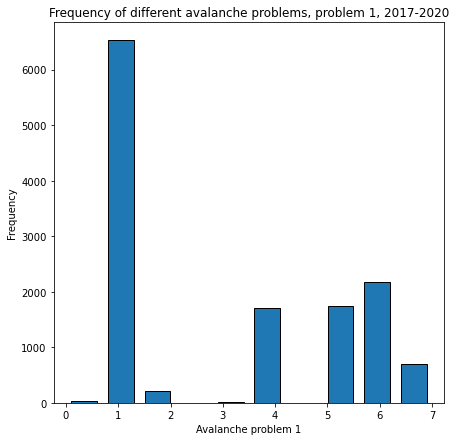

In [46]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.hist(labels['CLASS_problem_1'].values, edgecolor='k', rwidth=0.7)

ax.set_xlabel('Avalanche problem 1')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of different avalanche problems, problem 1, 2017-2020')
plt.show()

In [47]:
# tokenize and clean text data
prob0_raw, prob0_processed = process(text_prob0.values)
prob1_raw, prob1_processed = process(text_prob1.values)
prob2_raw, prob2_processed = process(text_prob2.values)
prob3_raw, prob3_processed = process(text_prob3.values)
prob4_raw, prob4_processed = process(text_prob4.values)
prob5_raw, prob5_processed = process(text_prob5.values)
prob6_raw, prob6_processed = process(text_prob6.values)
prob7_raw, prob7_processed = process(text_prob7.values)

In [48]:
prob0_raw[0]

['Snøbyger',
 'og',
 'litt',
 'vind',
 'onsdag/torsdag',
 'kan',
 'ha',
 'skapt',
 'mindre',
 'nysnøflak',
 'på',
 'vindutsatte',
 'steder,',
 'disse',
 'kan',
 'være',
 'ustabile.',
 'Nysnøen',
 'kan',
 'ligge',
 'over',
 'nedsnødd',
 'overflaterim,',
 'hvilket',
 'øker',
 'risikoen',
 'for',
 'skred',
 'i',
 'nysnøen.',
 'Utbredelsen',
 'av',
 'overflaterim',
 'er',
 'usikker.',
 'Det',
 'er',
 'først',
 'og',
 'fremst',
 'i',
 'nordlige',
 'og',
 'ytre',
 'del',
 'av',
 'regionen',
 'det',
 'har',
 'kommet',
 'nysnø.',
 'Kantkornlag',
 'vil',
 'de',
 'fleste',
 'steder',
 'ligge',
 'under',
 'hard',
 'fokksnø',
 'og',
 'være',
 'vanskelig',
 'å',
 'påvirke,',
 'og',
 'det',
 'er',
 'ikke',
 'observert',
 'skredaktivitet',
 'i',
 'dette',
 'laget',
 'i',
 'det',
 'siste.',
 'Skredfaren',
 'forventes',
 'å',
 'være',
 '2-moderat,',
 'og',
 '1-liten',
 'i',
 'områdene',
 'som',
 'ikke',
 'har',
 'fått',
 'nysnø',
 'av',
 'betydning.']

In [49]:
prob0_processed[0]

['snøbyger',
 'litt',
 'vind',
 'onsdagtorsdag',
 'skapt',
 'mindre',
 'nysnøflak',
 'vindutsatte',
 'steder',
 'ustabile',
 'nysnøen',
 'ligge',
 'nedsnødd',
 'overflaterim',
 'hvilket',
 'øker',
 'risikoen',
 'skred',
 'nysnøen',
 'utbredelsen',
 'overflaterim',
 'usikker',
 'først',
 'fremst',
 'nordlige',
 'ytre',
 'del',
 'regionen',
 'kommet',
 'nysnø',
 'kantkornlag',
 'fleste',
 'steder',
 'ligge',
 'under',
 'hard',
 'fokksnø',
 'vanskelig',
 'påvirke',
 'observert',
 'skredaktivitet',
 'laget',
 'siste',
 'skredfaren',
 'forventes',
 'områdene',
 'fått',
 'nysnø',
 'betydning']

In [50]:
# create lookup tables
vocab0, word_count0, _, _ = create_lookup_tables(prob0_processed)
vocab1, word_count1, _, _ = create_lookup_tables(prob1_processed)
vocab2, word_count2, _, _ = create_lookup_tables(prob2_processed)
vocab3, word_count3, _, _ = create_lookup_tables(prob3_processed)
vocab4, word_count4, _, _ = create_lookup_tables(prob4_processed)
vocab5, word_count5, _, _ = create_lookup_tables(prob5_processed)
vocab6, word_count6, _, _ = create_lookup_tables(prob6_processed)
vocab7, word_count7, _, _ = create_lookup_tables(prob7_processed)

In [51]:
vocab0[:to_print]

['skred',
 'snødekket',
 'snø',
 'steder',
 'stabilt',
 'lag',
 'lite',
 'ligger',
 'få',
 'venta']

In [52]:
[[word, word_count1[word]] for word in vocab0[:to_print]]

[['skred', 5918],
 ['snødekket', 4265],
 ['snø', 4439],
 ['steder', 1682],
 ['stabilt', 447],
 ['lag', 3247],
 ['lite', 1162],
 ['ligger', 1021],
 ['få', 617],
 ['venta', 66]]

In [54]:
# top n words
top_words0, top_counts0 = top_n_words(vocab0, word_count0, n)
top_words1, top_counts1 = top_n_words(vocab1, word_count1, n)
top_words2, top_counts2 = top_n_words(vocab2, word_count2, n)
top_words3, top_counts3 = top_n_words(vocab3, word_count3, n)
top_words4, top_counts4 = top_n_words(vocab4, word_count4, n)
top_words5, top_counts5 = top_n_words(vocab5, word_count5, n)
top_words6, top_counts6 = top_n_words(vocab6, word_count6, n)
top_words7, top_counts7 = top_n_words(vocab7, word_count7, n)

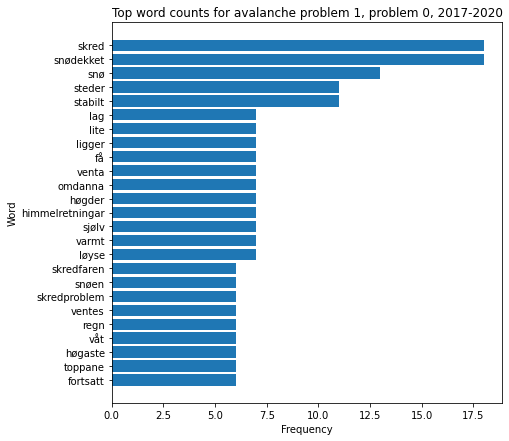

In [56]:
plot_top_word_counts(top_words0, top_counts0, 0, 'avalanche problem 1, problem')

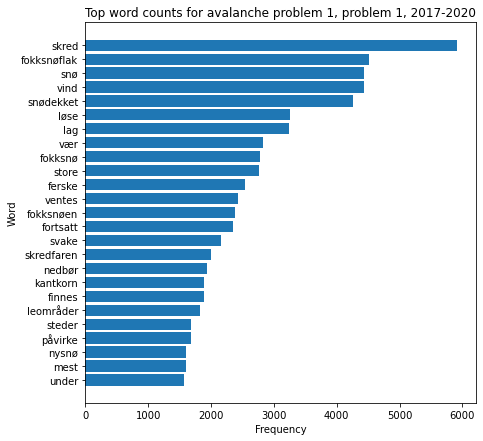

In [57]:
plot_top_word_counts(top_words1, top_counts1, 1, 'avalanche problem 1, problem')

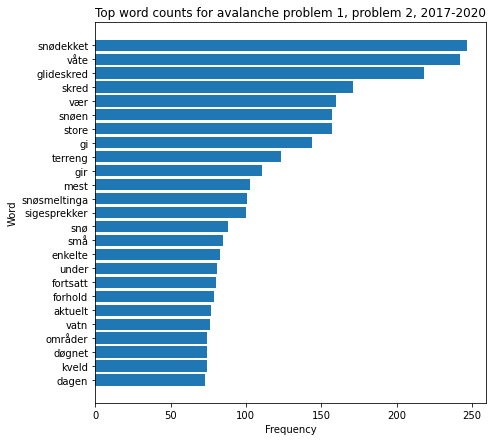

In [58]:
plot_top_word_counts(top_words2, top_counts2, 2, 'avalanche problem 1, problem')

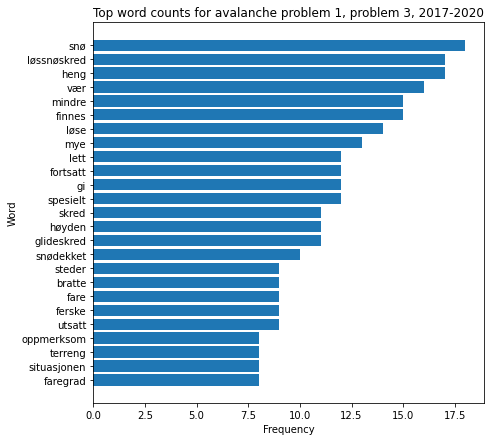

In [59]:
plot_top_word_counts(top_words3, top_counts3, 3, 'avalanche problem 1, problem')

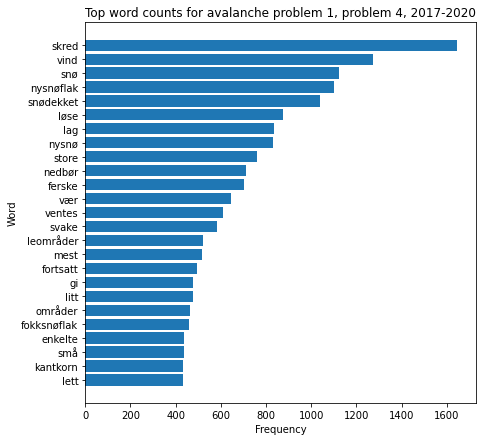

In [60]:
plot_top_word_counts(top_words4, top_counts4, 4, 'avalanche problem 1, problem')

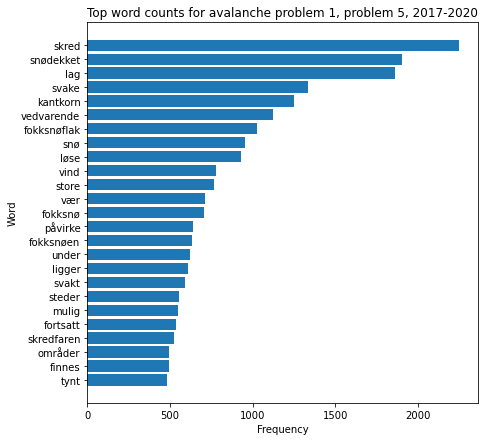

In [61]:
plot_top_word_counts(top_words5, top_counts5, 5, 'avalanche problem 1, problem')

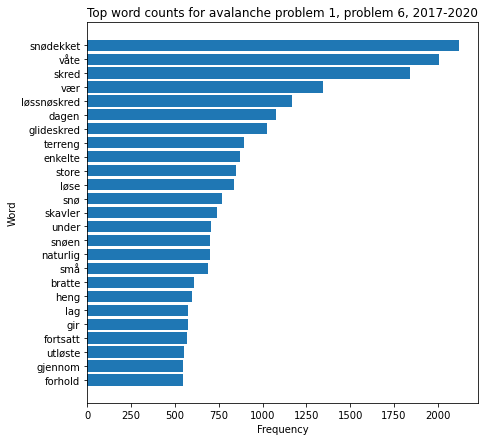

In [62]:
plot_top_word_counts(top_words6, top_counts6, 6, 'avalanche problem 1, problem')

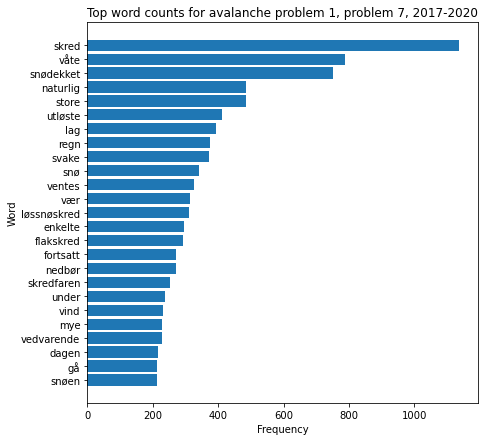

In [63]:
plot_top_word_counts(top_words7, top_counts7, 7, 'avalanche problem 1, problem')